In [1]:
from gurobipy import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapefile as shp
from collections import defaultdict

In [2]:
#M = 100000
maxOpenD = 6
maxOpenA = 3

maxDist_D = 150
maxDist_A = 350

#maxPopD- max capacity of each district court
#maxPopA - max capacity of each appeals court

#langS
#langD
#langA

### Extract Data

In [3]:
#Get Settlement List
#Sfile = "prov_code_1"
Sfile = "prov_code_24_25_26" #change to use different settlement files (updates console and solution log files)
#Sfile = "afg_ppl_settlement_pnt" 

Settlements=pd.read_csv("%s.csv"%Sfile,sep=",")
Settlements = Settlements[["OBJECTID","POPULATION", "LAT_Y","LON_X"]]
#Settlements=Settlements[[0,10,11]]
S = Settlements.shape[0]
Settlement_List = Settlements['OBJECTID'].tolist()

#Get District Court List
Districts = pd.read_csv("District_Courts.csv",sep=",")
Districts = Districts[["DIST_CODE","POP","LON_X", "LAT_Y"]]
#Districts = Districts[[1,4,5]]
D = Districts.shape[0]
District_List = Districts['DIST_CODE'].tolist()

#Get Appeals Court List
Appeals = pd.read_csv("Appeals_Courts.csv",sep=",")
Appeals = Appeals[["PROV_CODE","POP","LON_X", "LAT_Y"]]
#Appeals = Appeals[[1,4,5]]
A = Appeals.shape[0]
Appeals_List = Appeals['PROV_CODE'].tolist()

#### Create Data Subset for Settlements

#### ------------------------------------------------

In [4]:
#Settlements = Settlements.sample(frac = 0.02, replace = False, random_state = 23)
# = Settlements.shape[0]
#Settlement_List = Settlements['OBJECTID'].tolist()

### Set Parameters

####  ------------------------------------------------

In [5]:
#Create Dictionaries
Settlement_Dict = Settlements.set_index('OBJECTID').T.to_dict('list')
District_Dict = Districts.set_index('DIST_CODE').T.to_dict('list')
Appeals_Dict = Appeals.set_index('PROV_CODE').T.to_dict('list')

In [6]:
#Create Dictionaries for District Courthouse Distances

Dist_D = {}

R = 6371e3


for d in District_List:
    d_lon = District_Dict[d][1]
    d_lat = District_Dict[d][2]
    phi2 = np.radians(d_lat)
    

    for s in Settlement_List:
        s_lon = Settlement_Dict[s][2]
        s_lat = Settlement_Dict[s][1]
        phi1 = np.radians(s_lat)
        
        #Distance to District Court
        delta_phi = np.radians(d_lat - s_lat)
        delta_lambda = np.radians(d_lon - s_lon)
        a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        Dist_D[s,d] = (R * c)/1000
    

In [7]:
#Create Dictionaries for Appeals Courthouse Distances

Dist_A = {}

R = 6371e3

for a in Appeals_List:
    a_lon = Appeals_Dict[a][1]
    a_lat = Appeals_Dict[a][2]
    theta_3 = np.radians(a_lat)

    for s in Settlement_List:
        s_lon = Settlement_Dict[s][2]
        s_lat = Settlement_Dict[s][1]
        theta_1 = np.radians(s_lat)
        
        #Distance to District Court
        delta_theta_ = np.radians(a_lat - s_lat)
        delta_lambda = np.radians(a_lon - s_lon)
        a1 = np.sin(delta_theta_/2) * np.sin(delta_theta_/2) + np.cos(theta_1) * np.cos(theta_3) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
        c = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
        
        Dist_A[s,a] = (R * c)/1000
        
    

In [8]:
#Create Dictionaries for populations
s_pop = {}
for s in Settlement_List:
    s_pop[s] = Settlement_Dict[s][0] #population of each settlement

#CAPACITY OF COURTHOUSES DETERMINED BY CURRENT POPULATION IN PROVINCE/DISTRICT
#(MIGHT WANT TO USE STANDARD NUMBER ACROSS ALL COURTHOUSES??)
d_pop = {}
for d in District_List:
    d_pop[d] = District_Dict[d][0]
    
a_pop = {}
for a in Appeals_List:
    a_pop[a] = Appeals_Dict[a][0]

### Create Model

In [9]:
#Create Model
IP = Model("Afg_IP")
LP = Model("Afg_LP")

IP.Params.OutputFlag = 1
IP.params.LazyConstraints = 1
IP.Params.LogFile="log_LPIP_%s.log"%Sfile

LP.Params.OutputFlag = 1
LP.params.LazyConstraints = 1
LP.Params.LogFile="log_LPIP_%s.log"%Sfile

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter LogFile to log_LPIP_prov_code_24_25_26.log
   Prev: gurobi.log  Default: 
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter LogFile to log_LPIP_prov_code_24_25_26.log
   Prev: gurobi.log  Default: 


### Create Variables

##### Helper function

In [10]:
# Return value of variable
def VarVal(var):
    if (type(var) == gurobipy.Var):
        val = var.X

    else:
        val = 0
    return val

##### d_ij

In [11]:
# Create d_i_j variables
d_IP = {}
d_LP = {}
for i in Settlement_List:
    d_IP[i] = {}
    d_LP[i] = {}
    for j in District_List:
        if Dist_D[i,j] < maxDist_D:
            d_IP[i][j] = IP.addVar(vtype=GRB.BINARY, name='d_IP_%s_%s' % (i, j))
            d_LP[i][j] = LP.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='d_LP_%s_%s' % (i, j))
            #d[i][j].start=10000
        else:
            d_IP[i][j] = 0
            d_LP[i][j] = 0
IP.update()
LP.update()

In [12]:
# Create d_i_j transpose dictionary 
#d_t = defaultdict(dict)
#for key, val in d.items():
#    for subkey, subval in val.items():
#        d_t[subkey][key] = subval

##### a_ik

In [13]:
 # Create a_i_k variables
a_LP = {}
a_IP = {}
for i in Settlement_List:
    a_LP[i] = {}
    a_IP[i] = {}
    for k in Appeals_List:
        a_LP[i][k] = {}
        a_IP[i][k] = {}
        if Dist_A[i,k] < maxDist_A:
            a_LP[i][k] = LP.addVar(vtype=GRB.CONTINUOUS,lb=0,ub=1, name='a_LP_%s_%s' % (i, k))
            a_IP[i][k] = IP.addVar(vtype=GRB.BINARY, name='a_IP_%s_%s' % (i, k))
           #a[i][k].start=0
        else:
            a_IP[i][k] = 0
            a_LP[i][k] = 0
IP.update()
LP.update()

In [14]:
# Create a_i_k transpose dictionary 
#a_t = defaultdict(dict)
#for key, val in a.items():
#    for subkey, subval in val.items():
#        a_t[subkey][key] = subval

##### c_jk

In [15]:
# Create c_j_k variables
c_LP = {}
c_IP = {}
for j in District_List:
    c_LP[j] = {}
    c_IP[j] = {}
    for k in Appeals_List:
        c_LP[j][k] = LP.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='c_LP_%s_%s' % (j, k))
        c_IP[j][k] = IP.addVar(vtype=GRB.BINARY, lb=0, ub=1, name='c_IP_%s_%s' % (j, k))
LP.update()
IP.update()

In [16]:
# Create c_j_k transpose dictionary 
#c_t = defaultdict(dict)
#for key, val in c.items():
#    for subkey, subval in val.items():
#        c_t[subkey][key] = subval

##### openD

In [17]:
#Create openD variables
openD_LP = {}
openD_IP = {}
for j in District_List:
    openD_LP[j] = LP.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='openD_LP_%s' % (j))
    openD_IP[j] = IP.addVar(vtype=GRB.BINARY, lb=0, ub=1, name='openD_IP_%s' % (j))
LP.update()
IP.update()

##### openA

In [18]:
#Create openA variables
openA_LP = {}
openA_IP = {}
for k in Appeals_List:
    openA_LP[k] = LP.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='openA_LP_%s' % (k))
    openA_IP[k] = IP.addVar(vtype=GRB.BINARY, lb=0, ub=1, name='openA_IP_%s' % (k))
LP.update()
IP.update()

### Create Constraints

##### D_ij row sums and column sums

In [19]:
#One S -> D Assignment
for i in Settlement_List:
    LP.addConstr(quicksum(d_LP[i][j] for j in District_List) == 1)
    IP.addConstr(quicksum(d_IP[i][j] for j in District_List) == 1)
LP.update()
IP.update()

In [20]:
#Maximum District Courts Open
for j in District_List:
    LP.addConstr(quicksum(d_LP[i][j] for i in Settlement_List) <= S * openD_LP[j])
    IP.addConstr(quicksum(d_IP[i][j] for i in Settlement_List) <= S * openD_IP[j])
LP.update()
IP.update()

##### A_ik row sums and column sums

In [21]:
#One S -> A Assignment
for i in Settlement_List:
    LP.addConstr(quicksum(a_LP[i][k] for k in Appeals_List) == 1)
    IP.addConstr(quicksum(a_IP[i][k] for k in Appeals_List) == 1)
IP.update()

In [22]:
#Maximum Appeals Courts Open IP
for k in Appeals_List:
    LP.addConstr(quicksum(a_LP[i][k] for i in Settlement_List) <= S * openA_LP[k])
    IP.addConstr(quicksum(a_IP[i][k] for i in Settlement_List) <= S * openA_IP[k])
LP.update()
IP.update()

#### C_jk row sums and column sums

In [23]:
#One D -> A Assignment LP
for j in District_List:
    LP.addConstr(quicksum(c_LP[j][k] for k in Appeals_List) == openD_LP[j])
    IP.addConstr(quicksum(c_IP[j][k] for k in Appeals_List) == openD_IP[j])
LP.update()
IP.update()

In [24]:
#C constraints
for k in Appeals_List:
    LP.addConstr(quicksum(c_LP[j][k] for j in District_List) <= D * openA_LP[k])
    IP.addConstr(quicksum(c_IP[j][k] for j in District_List) <= D * openA_IP[k])
LP.update()
IP.update()

##### Max Open Courthouse Constraints

In [25]:
#LP Constraints
LP.addConstr(quicksum(openD_LP[j] for j in District_List) <= maxOpenD)
LP.addConstr(quicksum(openA_LP[k] for k in Appeals_List) <= maxOpenA)
LP.update()

#IP Constraints
IP.addConstr(quicksum(openD_IP[j] for j in District_List) <= maxOpenD)
IP.addConstr(quicksum(openA_IP[k] for k in Appeals_List) <= maxOpenA)
IP.update()

Max Population at Courthouse Constraints


In [26]:
#for j in District_List:
#    LP.addConstr(quicksum(s_pop[i]*d_LP[i][j] for i in Settlement_List) <= d_pop[j])
#    IP.addConstr(quicksum(s_pop[i]*d_IP[i][j] for i in Settlement_List) <= d_pop[j])

#for k in Appeals_List:
#    LP.addConstr(quicksum(s_pop[i]*a_LP[i][k] for i in Settlement_List) <= a_pop[k])
#    IP.addConstr(quicksum(s_pop[i]*a_IP[i][k] for i in Settlement_List) <= a_pop[k])
#LP.update()
#IP.update()

In [27]:
LP


<gurobi.Model Continuous instance Afg_LP: 9210 constrs, 318983 vars, Parameter changes: LogFile=log_LPIP_prov_code_24_25_26.log, LazyConstraints=1>

In [28]:
IP

<gurobi.Model MIP instance Afg_IP: 9210 constrs, 318983 vars, Parameter changes: LogFile=log_LPIP_prov_code_24_25_26.log, LazyConstraints=1>

### Set Objective Function

#### D_ij and A_ik

In [29]:
LP.setObjective(
        quicksum(   quicksum(   Dist_D[i,j]*d_LP[i][j] for i in Settlement_List)    for j in District_List) + \
        quicksum(   quicksum(   Dist_A[i,k]*a_LP[i][k] for i in Settlement_List)    for k in Appeals_List), GRB.MINIMIZE)
LP.update()

IP.setObjective(
        quicksum(   quicksum(    Dist_D[i,j]*d_IP[i][j] for i in Settlement_List)    for j in District_List) + \
        quicksum(   quicksum(    Dist_A[i,k]*a_IP[i][k] for i in Settlement_List)    for k in Appeals_List), GRB.MINIMIZE)
IP.update()

In [30]:
#POPULATION WEIGHTED OBJECTIVES
#LP.setObjective(
#        quicksum(   quicksum(   s_pop[i]*Dist_D[i,j]*d_LP[i][j] for i in Settlement_List)    for j in District_List) + \
#        quicksum(   quicksum(   s_pop[i]*Dist_A[i,k]*a_LP[i][k] for i in Settlement_List)    for k in Appeals_List), GRB.MINIMIZE)
#LP.update()

#IP.setObjective(
#        quicksum(   quicksum(    s_pop[i]*Dist_D[i,j]*d_IP[i][j] for i in Settlement_List)    for j in District_List) + \
#        quicksum(   quicksum(    s_pop[i]*Dist_A[i,k]*a_IP[i][k] for i in Settlement_List)    for k in Appeals_List), GRB.MINIMIZE)
#IP.update()

### Callback Function

In [31]:
def mycallback(model, where):        
    if where == GRB.Callback.MIPSOL:
        d_temp = {}
        a_temp = {}
        c_temp = {}
        for i in Settlement_List:
            d_temp[i] = {}
            a_temp[i] = {}
        for j in District_List:
            c_temp[j] = {}
        
        for i in Settlement_List:
            for j in District_List:
                if (type(d_IP[i][j]) == gurobipy.Var):
                    d_temp[i][j] = IP.cbGetSolution(d_IP[i][j])
                else:
                    d_temp[i][j] = 0
        
        for i in Settlement_List:
            for k in Appeals_List:
                if (type(a_IP[i][k]) == gurobipy.Var):
                    a_temp[i][k] = IP.cbGetSolution(a_IP[i][k])
                else:
                    a_temp[i][k] = 0
                
        for j in District_List:
            for k in Appeals_List:
                if (type(c_IP[j][k]) == gurobipy.Var):
                    c_temp[j][k] = IP.cbGetSolution(c_IP[j][k])
                else:
                    c_temp[j][k] = 0
                
        for i in Settlement_List:
            for j in District_List:
                for k in Appeals_List:
                    if (d_temp[i][j] + a_temp[i][k] - c_temp[j][k] > 1):
                        IP.cbLazy(d_IP[i][j] + a_IP[i][k] - c_IP[j][k] <= 1)
                    if (d_temp[i][j] + c_temp[j][k] - a_temp[i][k] > 1):
                        IP.cbLazy(d_IP[i][j] + c_IP[j][k] - a_IP[i][k] <= 1)             
                    


### Optimize

In [32]:
start_time = time.time()
LP.optimize()

Optimize a model with 9210 rows, 318983 columns and 638400 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 236 rows and 0 columns
Presolve time: 0.30s
Presolved: 8974 rows, 318983 columns, 638164 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 3.194e+05
 Factor NZ  : 3.980e+05 (roughly 130 MBytes of memory)
 Factor Ops : 2.914e+07 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.52 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 61 iterations and 0.54 seconds
Optimal objective  2.242797355e+05


In [33]:
#Set start values of c_IP
for i in Settlement_List:
    for j in District_List:
        
        openD_IP[j].start = round(openD_LP[j].X)
        if (type(d_LP[i][j]) == gurobipy.Var):
                d_IP[i][j].start = round(d_LP[i][j].X)
                
        for k in Appeals_List:
            openA_IP[k].start = round(openA_LP[k].X)
            c_IP[j][k].start = round(c_LP[j][k].X)

            if (type(a_LP[i][k]) == gurobipy.Var):
                a_IP[i][k].start = round(a_LP[i][k].X)
            

In [34]:
IP.optimize(mycallback)

end_time = time.time()

Optimize a model with 9210 rows, 318983 columns and 638400 nonzeros
Variable types: 0 continuous, 318983 integer (318983 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 236 rows and 0 columns
Presolve time: 0.97s
Presolved: 8974 rows, 318983 columns, 638164 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint R4285 by 1.000000000

Variable types: 0 continuous, 318983 integer (318983 binary)
Found heuristic solution: objective 906927.40205

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.340000e+03   0.000000e+00     96s
    8454    2.2427974e+05   0.000000e+00   0.000000e+00     96s

Root relaxation: objective 2.242797e+05, 8454 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

Exception KeyboardInterrupt in 'gurobipy.callbackstub' ignored


H    0     2                    391136.74887 290787.698  25.7%     -  802s
     0     2 291870.749    0 9917 391136.749 291870.749  25.4%     -  802s
     1     4 292741.635    1 9972 391136.749 291919.483  25.4%   639  808s
     3     6 293084.507    2 11852 391136.749 292735.478  25.2%  1184  829s
     5     8 293156.412    3 11823 391136.749 292775.799  25.1%  1230  834s
     7     9 294821.184    4 12269 391136.749 292775.799  25.1%  1139  837s
    11    11 293609.157    5 10975 391136.749 292775.799  25.1%   887  844s
    13    13 293733.133    6 10955 391136.749 292775.799  25.1%   785  850s
    15    17 293827.642    7 10933 391136.749 292775.799  25.1%   738  856s
    17    17 294120.629    8 10863 391136.749 292775.799  25.1%   780 8894s
    20    21 294200.843    9 10749 391136.749 292775.799  25.1%   696 8906s
    23    26 295033.965   10 10296 391136.749 292775.799  25.1%   687 8911s
    25    24 295094.217   11 10283 391136.749 292775.799  25.1%   653 8916s
    30    33 29

### Output Solution

In [35]:
print(end_time-start_time)
LP.write("out_LPIP_%s.sol"%Sfile)

14216.2539999


In [36]:
GRB.Attr

###  Plotting

#### DOUT

In [37]:
# DOUT - District Assignments

DOUT = pd.DataFrame.from_dict({(i,j): VarVal(d_IP[i][j]) 
                           for i in d_IP.keys() 
                           for j in d_IP[i].keys()},
                           orient='index')

Settlements_DOUT = [i[0] for i in DOUT.index]
Districts_DOUT = [i[1] for i in DOUT.index]

DOUT['Settlement'] = Settlements_DOUT
DOUT['DistrictCourts'] = Districts_DOUT

DOUT = DOUT[DOUT[0] == 1.0]

#### AOUT

In [38]:
#AOUT - Appeals Assignments

AOUT = pd.DataFrame.from_dict({(i,j): VarVal(a_IP[i][j]) 
                           for i in a_IP.keys() 
                           for j in a_IP[i].keys()},
                           orient='index')

Settlements_AOUT = [i[0] for i in AOUT.index]
Appeals_AOUT = [i[1] for i in AOUT.index]

AOUT['Settlement'] = Settlements_AOUT
AOUT['AppealsCourts'] = Appeals_AOUT

AOUT = AOUT[AOUT[0] == 1.0]

#### COUT

In [39]:
#COUT - Appeals Assignments

COUT = pd.DataFrame.from_dict({(i,j): VarVal(c_IP[i][j]) 
                           for i in c_IP.keys() 
                           for j in c_IP[i].keys()},
                           orient='index')

Districts_COUT = [i[0] for i in COUT.index]
Appeals_COUT = [i[1] for i in COUT.index]

COUT['DistrictCourts'] = Districts_COUT
COUT['AppealsCourts'] = Appeals_COUT

COUT = COUT[COUT[0] == 1.0]

#### Plot all Locations

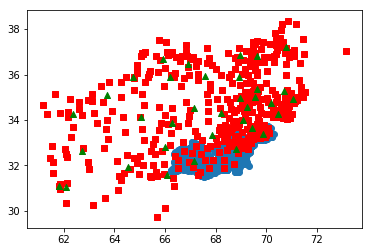

In [40]:
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's')
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^')
plt.show()

#### Plotting Assignments

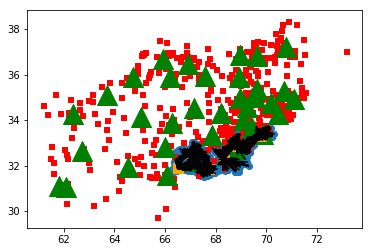

In [41]:
#Drawing Lines
#plt.figure(figsize=(14,14))

#Plotting Points    
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's',s=25)
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^',s = 400)

for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]
    X = [Sett.iloc[0,3],Dist.iloc[0,2]]
    Y = [Sett.iloc[0,2],Dist.iloc[0,3]]
    plt.scatter(Dist.iloc[0,2],Dist.iloc[0,3], color='Orange', marker = 's',s = 100)
    plt.plot(X,Y,zorder=1, color="Black")


#axes = plt.gca()
#axes.set_xlim([65,70])
#axes.set_ylim([30,35])

plt.show()

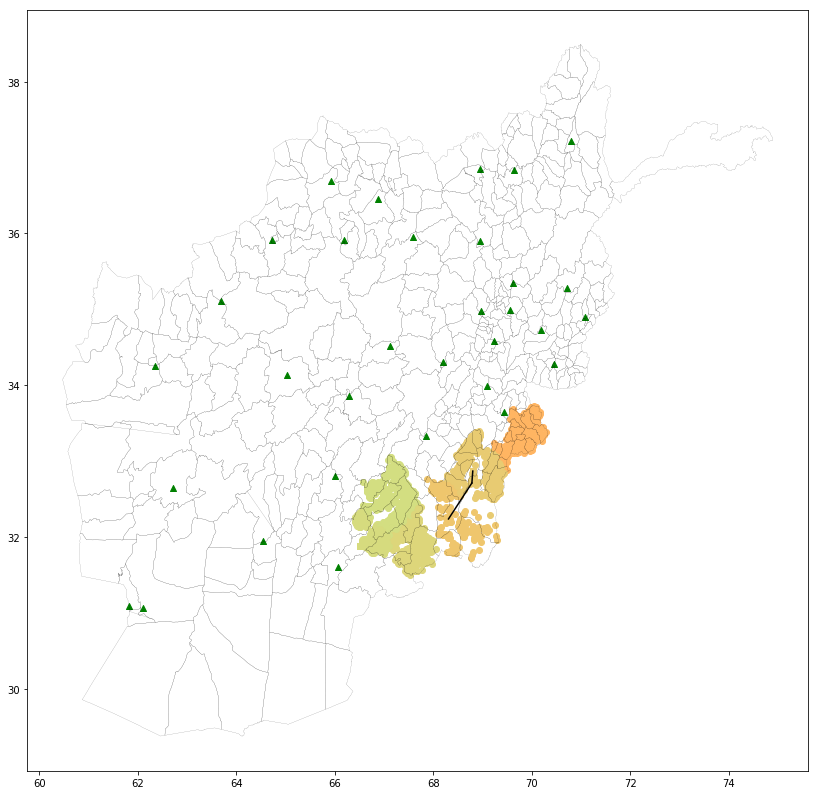

In [42]:
#Draw Lines
plt.figure(figsize=(14,14))

for index,row in COUT.iterrows():
    d = row['DistrictCourts'] 
    a = row['AppealsCourts']

    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    App = Appeals.loc[Appeals['PROV_CODE'] == a]

    X = [Dist.iloc[0,2],App.iloc[0,2]]
    Y = [Dist.iloc[0,3],App.iloc[0,3]]

    plt.plot(X,Y,zorder=1, color="Black")
    
clr = cm.rainbow(np.linspace(0, 1, D))
for a in range(A):
    X = Appeals.iloc[a,2]
    Y = Appeals.iloc[a,3]
    plt.scatter(X,Y, color="Green", marker = '^')
    
for index,row in DOUT.iterrows():   
    d = row['DistrictCourts'] 
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    X = Dist.iloc[0,2]
    Y = Dist.iloc[0,3]
    c = Dist.index[0]
    plt.scatter(X,Y, color=clr[c], marker = 's')
    
for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]

    c = Dist.index[0]
    X = Sett.iloc[0,3]                                                     
    Y = Sett.iloc[0,2]
    plt.scatter(X,Y, color=clr[c])
          
#axes = plt.gca()
#axes.set_xlim([66,71])
#axes.set_ylim([30,35])

sf = shp.Reader("Afghanistan_Districts","rb")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.1)
plt.show()